## Work
1. 請比較 SGD optimizer 不同的 momentum 及使用 nesterov 與否的表現

In [1]:
import os
from tensorflow import keras

# 本作業可以不需使用 GPU, 將 GPU 設定為 "無" (若想使用可自行開啟)
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# 資料前處理 - X 標準化
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# 資料前處理 -Y 轉成 onehot
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
x_train.shape[-1]

3072

In [6]:
def build_mlp(input_shape, output_num= 10):
    """Code Here
    建立你的神經網路
    """
    input_layer = keras.layers.Input(input_shape)
    x = keras.layers.Dense(units=1024, activation='relu')(input_layer)
    x = keras.layers.Dense(units=1024, activation='relu')(x)
    x = keras.layers.Dense(units=512, activation='relu')(x)
    x = keras.layers.Dense(units=512, activation='relu')(x)
    out = keras.layers.Dense(units=output_num, activation='sigmoid')(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [7]:
"""Code Here
設定超參數
"""
epoch = 50
learning_rate=0.0001
momentum = [0.95, 0.6, 0.1] 
nesterov = [True, False]
batch_size = 256

Signature: compile(source, filename, mode, flags=0, dont_inherit=False, optimize=-1)
Docstring:
Compile source into a code object that can be executed by exec() or eval().

The source code may represent a Python module, statement or expression.
The filename will be used for run-time error messages.
The mode must be 'exec' to compile a module, 'single' to compile a
single (interactive) statement, or 'eval' to compile an expression.
The flags argument, if present, controls which future statements influence
the compilation of the code.
The dont_inherit argument, if true, stops the compilation inheriting
the effects of any future statements in effect in the code calling
compile; if absent or false these statements do influence the compilation,
in addition to any features explicitly specified.
Type:      builtin_function_or_method


In [12]:
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
result ={}
for mom in momentum:
    for nest in nesterov:
        keras.backend.clear_session()
        model = build_mlp(input_shape=x_train.shape[1:])
        model.summary()
        opt = keras.optimizers.SGD(lr=learning_rate, momentum=mom, nesterov=nest)
        model.compile(loss='categorical_crossentropy', metrics=["accuracy"], optimizer=opt)
        
        model.fit(x_train, y_train,
                  epochs=epoch,
                  batch_size=batch_size,
                  validation_data=(x_test, y_test),
                  shuffle=True)
        
        train_loss = model.history.history["loss"]
        valid_loss = model.history.history["val_loss"]
        train_acc = model.history.history["accuracy"]
        valid_acc = model.history.history["val_accuracy"]
        
        exp_nam_tag = "nesterov = %s, momentum= %.2f" % (nest,mom)
        result[exp_nam_tag] ={'train_loss' : train_loss,
                              'valid_loss' : valid_loss,
                              'train_acc' : train_acc,
                              'valid_acc' : valid_acc
                              }

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
dense (Dense)                (None, 1024)              3146752   
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dense_2 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_3 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_4 (Dense)              (None, 10)                5130      
Total params: 4,988,938
Trainable params: 4,988,938
Non-trainable params: 0
___________________________________________________

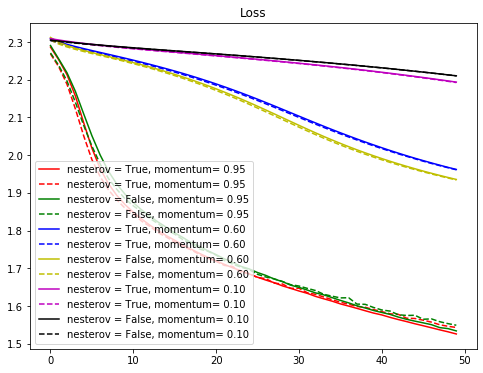

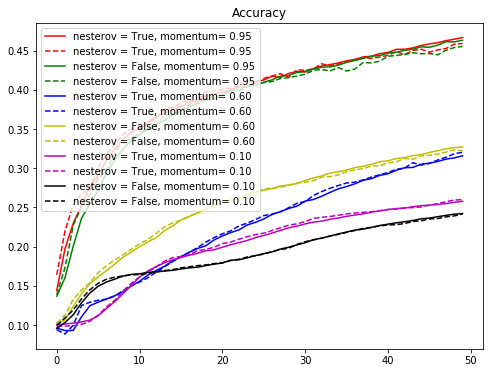

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline
"""Code Here
將結果繪出
"""
color_bar = ["r", "g", "b", "y", "m", "k"]
plt.figure(figsize=(8,6))
for i, cond in enumerate(result.keys()):
    plt.plot(range(len(result[cond]['train_loss'])),result[cond]['train_loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(result[cond]['valid_loss'])),result[cond]['valid_loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(result.keys()):
    plt.plot(range(len(result[cond]['train_acc'])),result[cond]['train_acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(result[cond]['valid_acc'])),result[cond]['valid_acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()